<div>
<img src="images/anyaface.jpg" width="200"/>
</div>

# 1. Introduction

This project is a capstone project for the Google Data Analytics Course. This specific project require us to choose any business question that interest us, find our own dataset and perform an analysis on it. The project scenario is something I made up and use to get the project rolling.

### Project Scenario

We are working as a junior analyst for a hypothetical company that offers online streaming service for popular shows. With the growing popularity of japanese animation known as anime, the company want to start including anime in their line up of shows. However, the company's budget only allows them to purchase the licensing of up to 5 upcoming anime series. Nowadays bidding for an anime license occurs roughly a year in advance and before production even begins. Provided with only a proof of concept and a rough outline of how an anime series may pan out, the higher up need more information before coming to a decision. The higher up would like to a better understanding of what to look for when deciding to purchase the license to an anime. We've been asked to find trend that indicate an anime will be popular and get a list of recommendation for the upcoming season based on our findings. Since anime bidding are done privately and an anime's public release date can be announced anywhere between a month to a year in advance, we are not informed of which anime is being released for the next season nor what anime are up for bidding as of this writing. Thus we will use the current season of anime for out list of recommendation. 

Source: https://www.animenewsnetwork.com/feature/2021-08-02/how-much-does-it-cost-to-license-anime-series/.175579#:~:text=Currently%2C%20these%20titles%20often%20go,%24500%2C000%20an%20episode%20to%20produce.

### Deliverables
1. Clear summary of business task
2. Description of all dataset used 
3. Documentation of the cleaning and/or manipulation of the datasets
4. Summary of our analysis
5. Collection of visualization that support the analysis and key findings
6. List of additional deliverable that is useful for future analysis
7. List of anime recommendation for current anime season

# 2. Ask

### 2.1 Business Task
1. Is there is a relationship between viewer interest and viewer overall enjoyment? 
2. Which rating is more appeal to viewers? 
3. How episodes would be ideal for an anime?
4. Which genre, studio and producers has the most potential to draw in large audiences?
5. What trends can be found in competitor's selection and how can we use these trends? 
6. Does the type of source material affect an anime's popularity?

### 2.2 Key Stakeholders
1. The Board of Director 
2. The department that handles acquisition of streaming licenses


# 3.Prepare

### 3.1 Dataset Info

The dataset, Anime Recommendation Database 2020, is hosted on Kaggle and provided by Hernan Valdivieso. The data obtained through data scraped from Animelist.net, a website users use to catalog anime they have interest in and rate anime. The dataset was last updated roughly 2 years ago. We selected this dataset over others found on Kaggle because this dataset provides the most amount of information while being relatively up to date.

The dataset contains three important tables.
1. anime.csv - contain general information on every anime
2. animelist.csv - list of all anime registered by the users with the respective score, watching status and numbers of episodes watched
3. rating_complete.csv - subset of animelist.csv. Contain only users that have finished watching an anime and give it a score.

For our purposes, we primarily use anime.csv tables. The anime table contains information on 17562 different anime. The table also provided an anime's average score, genre, episode count, release date, producer, licensor, studio, source, rating, members interested and few other useful info.

### 3.2 Limitations

Although the dataset is somewhat recent, it doesn't reflect the improvement/decline of quality of studios and producers in recent times. Oftentimes in the anime community, if an upcoming anime possess highly praised source material, it is a strong indicator the anime will draw large amount of attention. This particular factor is not accounted for within the dataset. My Anime List is a site generally used by people who watch plenty of anime, thus reflecting the interest of those people. As a result, although Anime List is probably the most accurate representation of anime watchers, it doesn't encompass the entire sphere of anime watchers.

### 3.3 Licensing and Privacy

This dataset is licensed under CC0: Public Domain thus freely available online for public use. This dataset may be copied, modified and distributed for any purpose without needing attribution or permission. All user personal information is excluded in the dataset.

### 3.4 Constraints
1. The company is only interested in anime tv series and not other format like movies. So we will perform our analysis on only anime TV series
2. The company want the anime length to be in line with industry standards. As a result we will remove anime with average run time of less than 20 min per episodes. We don't want anime with too little episode count nor anime with too many episode counts. So we will only look at anime between 8-60
3. The company wants to license anime that would be popular in modern day. To handle this, we will use on anime made between the year 2014-2020. The year 2021 contain anime still airing so we will exclude it.

# 4. Process

### 4.1 Import Packages

In [1]:
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns

### 4.2 Utility Function

In [2]:
# Functions used for reoccurring processes or to simplify a process
# Convert strings into a list
def string_to_list(string):
    if pd.isna(string):
        return string
    else:
        list = string.split(', ')
        return list

# Convert string to integer while keeping unknowns as n/a
def string_to_integer(string):
    if pd.isna(string):
        return string
    else:
        return int(string)
        
def string_to_float(string):
    if pd.isna(string):
        return string
    else:
        return float(string)
        
# Simplify rating names
def clean_rating(string):
    if string == 'PG - Children':
        return 'PG'
    elif string == 'R+ - Mild Nudity':
        return 'R+'
    elif string == 'PG-13 - Teens 13 or older':
        return 'PG13'
    elif string == 'R - 17+ (violence & profanity)':
        return 'R'
    elif string == 'G - All Ages':
        return 'G'
    else:
        return 'Unrated'

# Combine all list within one column into one big list
def combine_lists(column):
    df_removed_na = column.dropna(axis=0)
    return pd.Series([x for list in df_removed_na for x in list])

# Filter columns containing list based on items within the list
def filter_columnlist(df, column, filter, include=True):
    """ 
    Example: filter_columnlist(Dataframe, 'Column Name', ['Item You Are Looking For'])
    Include = True if looking for the item, Include = False if removing item from dataframe 
    """
    if include == True:
        na_mask = df[column].replace(np.nan, 'Unknown')
        filter_index = na_mask.apply(lambda x: any(item for item in filter if item in x))
        return df[filter_index]
    else:
        na_mask = df[column].replace(np.nan, 'Unknown')
        filter_index = na_mask.apply(lambda x: any(item for item in filter if item in x))
        return df[~filter_index]

### 4.3 Load Dataset

In [3]:
anime = pd.read_csv("Data/anime.csv", na_values=['Unknown'])
anime

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26.0,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1.0,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26.0,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26.0,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,盗墓笔记之秦岭神树,ONA,NaN,"Apr 4, 2021 to ?",NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,見える子ちゃん,TV,NaN,2021 to ?,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17559,48488,Higurashi no Naku Koro ni Sotsu,NaN,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,NaN,"Jul, 2021 to ?",Summer 2021,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,ヤマノススメ Next Summit,TV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.4 Filter Unwanted Data

Actions Performed 
1. Drop columns that offer little to no useful info and columns that are similar to other columns
2. Convert to proper data type
3. Filter out movies, short and etc. Keep only anime that are listed as TV.
4. Drop anime missing a duration value
5. Remove anime that are less than 20 min in length and shorter than 8 episodes. We also exclude anime longer than 60 episodes. Drop episodes that are NA. 
6. Remove anime not yet premiered and anime release before 2015
7. Simplify rating and add drop ratio column
8. Categorize anime as one season, two season, three season or more than three seasons



In [4]:
# Drop columns that offer little to no useful info and columns that are similar to other columns
anime.drop_duplicates(subset=['MAL_ID', 'Name', 'English name', 'Japanese name'], inplace=True)
anime_list = anime[[
    'MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes', 'Premiered', 'Producers', 'Licensors', 
    'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity', 'Members', 'Dropped'
    ]]


In [5]:
# Convert to proper data type
anime_list['Genres'] = anime_list['Genres'].apply(string_to_list)
anime_list['Producers'] = anime_list['Producers'].apply(string_to_list)
anime_list['Studios'] = anime_list['Studios'].apply(string_to_list)
anime_list['Licensors'] = anime_list['Licensors'].apply(string_to_list)
anime_list['Episodes'] = anime_list['Episodes'].apply(string_to_integer)
anime_list['Score'] = anime_list['Score'].apply(string_to_float)

# Filter out movies, short and etc. 
anime_list = anime_list[anime_list['Type'] == 'TV']

# Most anime episodes last at least 20 mins and are at least 8 episodes long. We aren't interested in long running anime so we exclude anime with more than 60 episodes. 
# Missing episode length typically indicate anime is still ongoing thus we can drop it. 
anime_list = anime_list[(anime_list['Episodes'] >= 8) & (anime_list['Episodes'] <= 60)]
anime_list['Duration'] = anime_list['Duration'].str.replace(r'\D', '')
anime_list['Duration'] = anime_list['Duration'].apply(string_to_integer)
anime_list = anime_list[anime_list['Duration'] >= 20]

# Exclude anime not premiered as of data set release and anime released too long ago. We keep anime released after 2015 since this is roughly the time anime began transitioning from weekly release to modern release schedule.
anime_list[['Season', 'Year']] = anime_list['Premiered'].str.split(' ', expand=True)
anime_list['Year'] = anime_list['Year'].apply(string_to_integer)
anime_list = anime_list[~((anime_list['Year'] >= 2021) | (anime_list['Year'] < 2015))]

# Simplify rating name and create a Drop Ratio column
anime_list['Rating'] = anime_list['Rating'].apply(clean_rating)
anime_list['DropRatio(%)'] = anime_list['Dropped'] / anime_list['Members'] * 100

# Categorize anime as one season, two season, three season or more than three seasons
# Episode range per season
# One Season: 9-15 episodes
# Two Season: 16-28 episodes
# Three Season: 29-40 episodes
# Four or More Season: 41 episodes or more

def run_length(episode_count):
    if pd.isna(episode_count):
        return np.nan
    elif episode_count < 16:
        return 'One Season'
    elif 16 <= episode_count < 29:
        return 'Two Season'
    elif 29 <= episode_count < 41:
        return 'Three Season'
    else:
        return 'Four or more Season' 
anime_list['RunLength'] = anime_list['Episodes'].apply(run_length)

anime_list


C:\Users\Bob\AppData\Local\Temp/ipykernel_19468/1973474380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_list['Genres'] = anime_list['Genres'].apply(string_to_list)
C:\Users\Bob\AppData\Local\Temp/ipykernel_19468/1973474380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_list['Producers'] = anime_list['Producers'].apply(string_to_list)
C:\Users\Bob\AppData\Local\Temp/ipykernel_19468/1973474380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,MAL_ID,Name,Score,Genres,Type,Episodes,Premiered,Producers,Licensors,Studios,...,Duration,Rating,Ranked,Popularity,Members,Dropped,Season,Year,DropRatio(%),RunLength
4816,6907,Mikan-Seijin,5.84,[Comedy],TV,26.0,NaN,NaN,NaN,NaN,...,22.0,G,8717.0,12330,460,55,NaN,NaN,11.956522,Two Season
5603,8999,Origami Warriors,NaN,"[Action, Adventure]",TV,52.0,NaN,[SBS TV Production],NaN,NaN,...,30.0,Unrated,11399.0,13043,348,43,NaN,NaN,12.356322,Four or more Season
5924,9822,Xiang Qi Wang,NaN,[Game],TV,26.0,NaN,NaN,NaN,NaN,...,24.0,PG,12869.0,12259,471,61,NaN,NaN,12.951168,Two Season
5992,9948,Wo Wei Ge Kuang,NaN,[Music],TV,52.0,NaN,NaN,NaN,NaN,...,22.0,PG13,12863.0,13520,295,46,NaN,NaN,15.593220,Four or more Season
5996,9952,Wei Qi Shao Nian,NaN,"[Game, Historical]",TV,26.0,NaN,[CCTV Animation],NaN,NaN,...,22.0,PG,12819.0,12327,460,60,NaN,NaN,13.043478,Two Season
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,42468,Zhandou Wang Zhi Jufeng Zhan Hun 5,NaN,"[Action, Kids]",TV,26.0,Fall 2018,NaN,NaN,[Alpha Animation],...,23.0,PG,13120.0,17186,67,14,Fall,2018.0,20.895522,Two Season
17066,42668,Taisou Zamurai,7.27,[Sports],TV,11.0,Fall 2020,NaN,[Funimation],[MAPPA],...,23.0,PG13,2470.0,2743,34725,2732,Fall,2020.0,7.867531,One Season
17086,42740,Ji Jia Shou Shen Zhi Baolie Feiche,NaN,"[Action, Adventure, Cars]",TV,40.0,Spring 2016,NaN,NaN,[Alpha Animation],...,23.0,PG,14655.0,17160,68,15,Spring,2016.0,22.058824,Three Season
17097,42765,Ji Jia Shou Shen,NaN,"[Action, Adventure]",TV,26.0,NaN,[Alpha Animation],NaN,[Qianqi Animation],...,23.0,PG,14657.0,17489,35,7,NaN,NaN,20.000000,Two Season


### 4.5 Cleaning Missing Values


<AxesSubplot:>

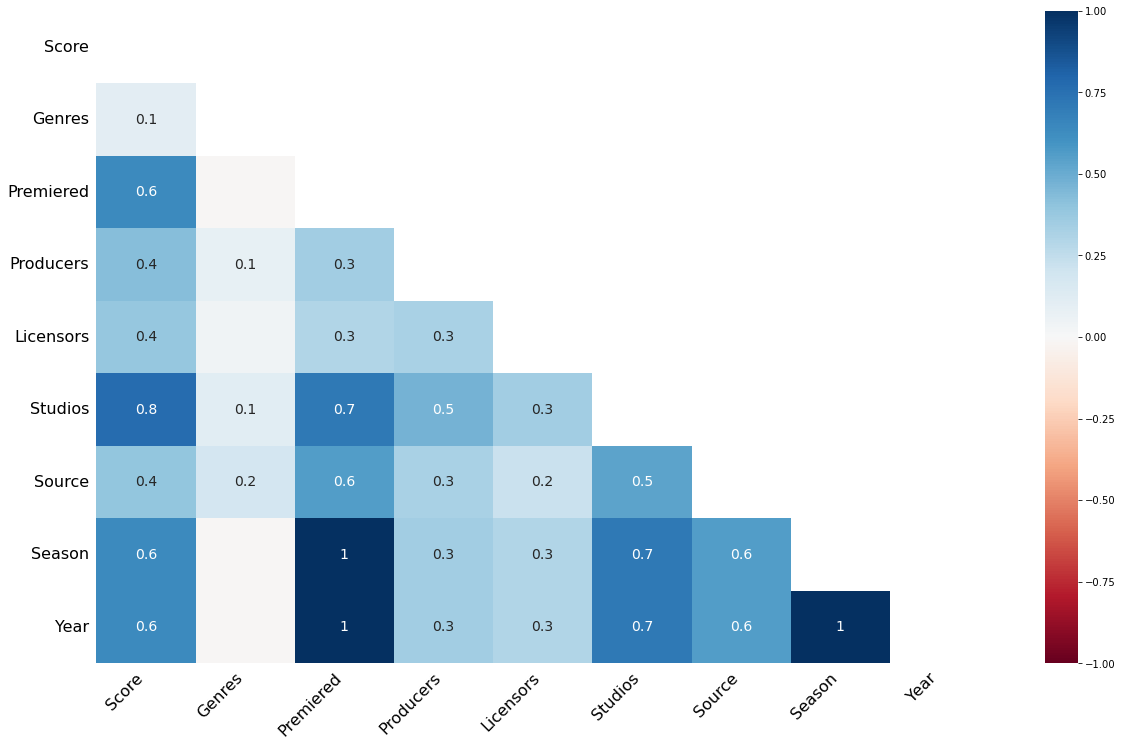

In [6]:
# Check to see if there is any correlation between missing values
msno.heatmap(anime_list)

<AxesSubplot:>

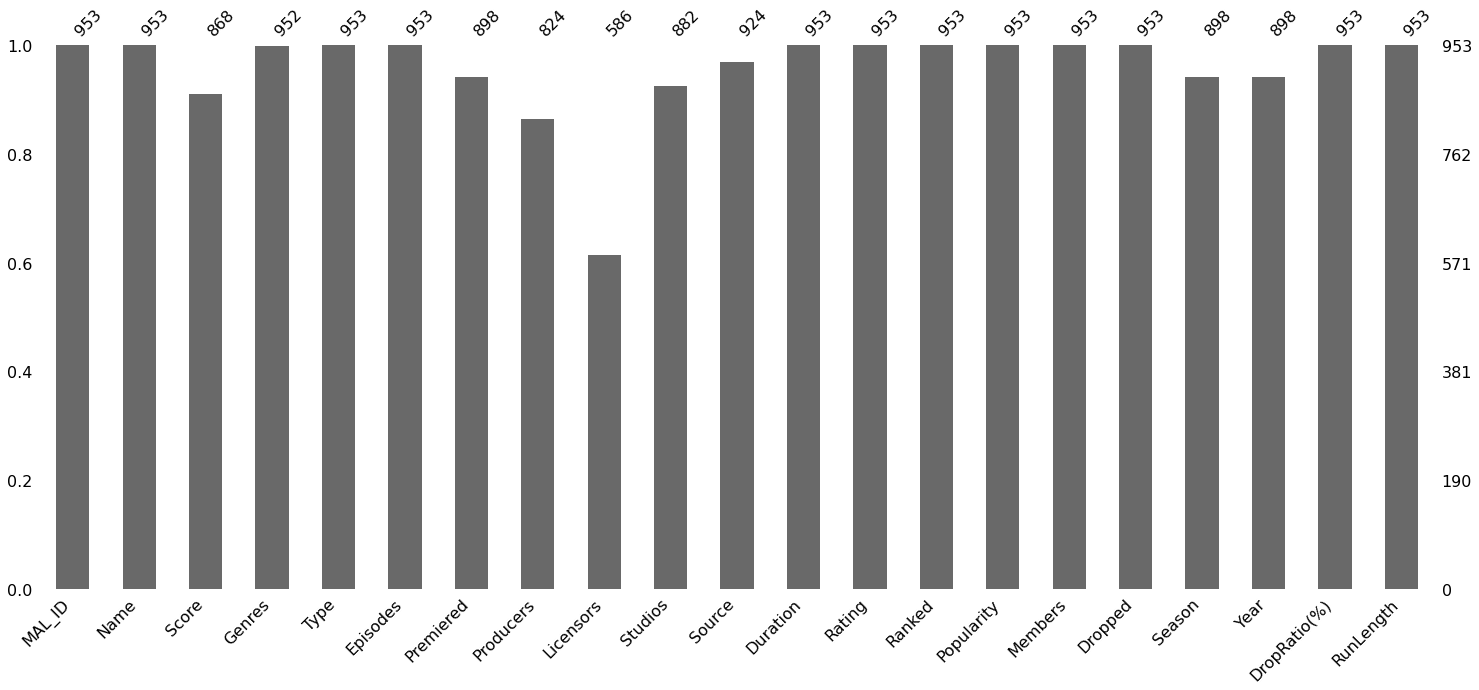

In [7]:
# Show count of missing values
msno.bar(anime_list)

In [8]:
anime_list.dropna(axis=0, thresh=3, subset=['Score', 'Licensors', 'Studios', 'Producers', 'Premiered', 'Source'], inplace=True)

In [9]:
# Clean up Missing Values
anime_list['Licensors'] = anime_list['Licensors'].apply(lambda name: ["Other Licensors"] if isinstance(name, list) == False else name)
anime_list['Producers'] = anime_list['Producers'].apply(lambda name: ["Other Producer"] if isinstance(name, list) == False else name)
anime_list['Studios'] = anime_list['Studios'].apply(lambda name: ["Other Studio"] if isinstance(name, list) == False else name)
anime_list['Premiered'] = anime_list['Premiered'].apply(lambda date: "Unspecified" if pd.isna(date) == True else date)
anime_list['Season'] = anime_list['Season'].apply(lambda date: "Unspecified" if pd.isna(date) == True else date)
anime_list['Year'] = anime_list['Year'].apply(lambda date: "Unspecified" if pd.isna(date) == True else date)
anime_list['Source'] = anime_list['Source'].apply(lambda source: "Unspecified" if pd.isna(source) == True else source)

# Fill missing score with average score of original data 
anime_list['Score'].fillna(anime['Score'].mean(), inplace=True)



<AxesSubplot:>

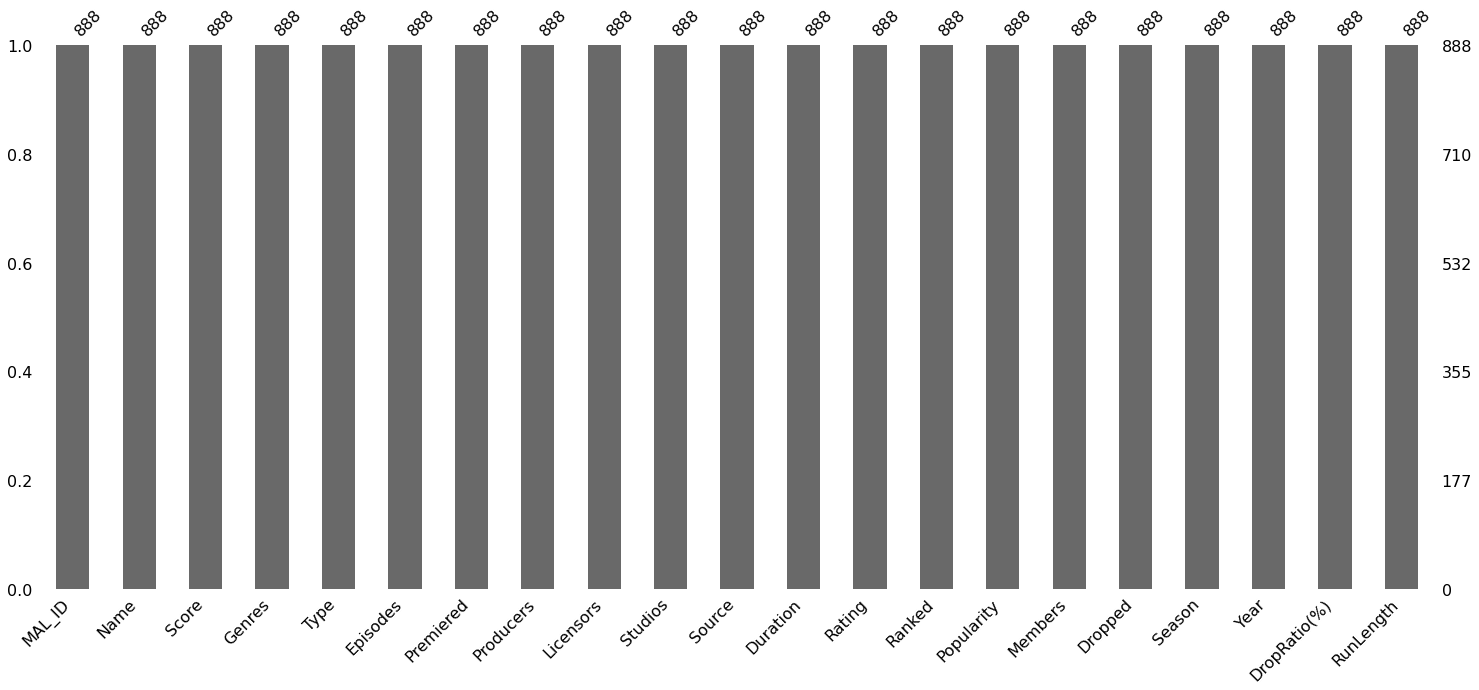

In [10]:
# Check to see all missing values are taken care of 
msno.bar(anime_list)

### 4.6 Create Clean Version

In [11]:
anime_list.to_csv('Data/anime_clean.csv')

# 5. Analyze & Share/Visualization

In [12]:
# list of all unique entries for each feature
list_of_genres = combine_lists(anime_list['Genres']).unique()
list_of_producers = combine_lists(anime_list['Producers']).unique()
list_of_licensors = combine_lists(anime_list['Licensors']).unique()
list_of_studios = combine_lists(anime_list['Studios']).unique()
list_of_sources = anime_list['Source'].dropna().unique()
list_of_ratings = ['G', 'PG', 'PG13', 'R', 'R+']
list_of_seasons = ['Winter', 'Spring', 'Summer', 'Fall']
list_of_years = np.arange(2015, 2021)
list_of_premiered = []
for year in list_of_years:
    for season in list_of_seasons:
        list_of_premiered.append(season + ' ' + year.astype('str'))
list_of_run_length = ['One Season', 'Two Season', 'Three Season', 'Four or more Season']

### 5.1. Is There a Relationship Between Score and Viewer Interest in an Anime

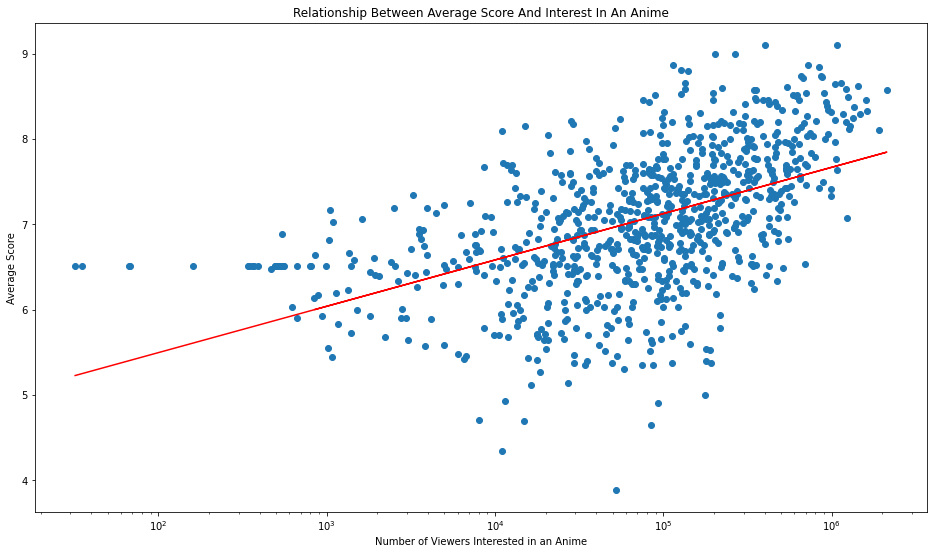

In [13]:
df = anime_list.dropna(axis=0, subset=['Score', 'Rating'])

fig, ax = plt.subplots(figsize = (16, 9))
x, y = df['Members'], df['Score']
ax.scatter(x, y)
ax.set_xlabel('Number of Viewers Interested in an Anime')
ax.set_ylabel('Average Score')
ax.set_title('Relationship Between Average Score And Interest In An Anime')
m, b = np.polyfit(np.log10(x), y, 1)
plt.plot(x, m * np.log10(x) + b, color = 'red')
fig.patch.set_facecolor('xkcd:white')
ax.set_xscale('log')

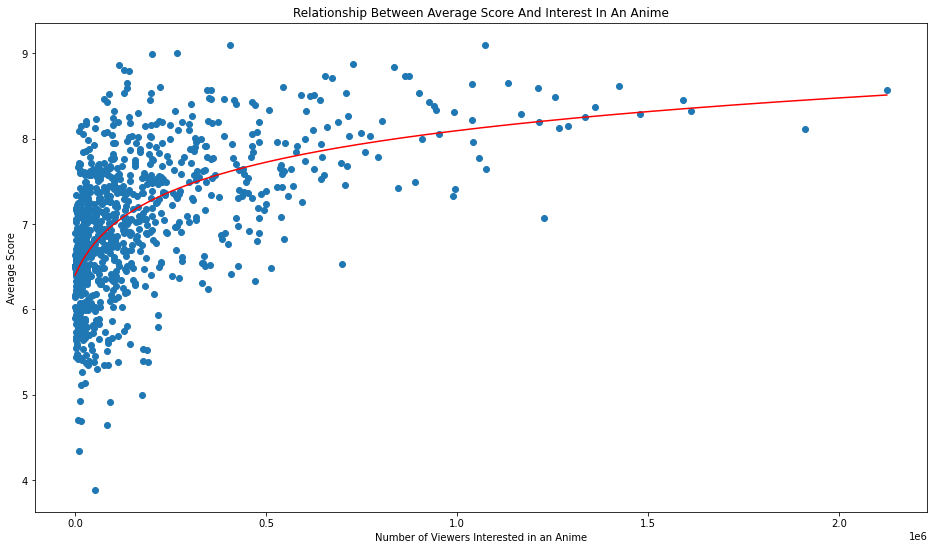

In [14]:
df = anime_list.dropna(axis=0, subset=['Score', 'Rating'])

# Plot scatter plot
fig, ax = plt.subplots(figsize = (16, 9))
x, y = df['Members'], df['Score']
ax.scatter(x, y)
ax.set_xlabel('Number of Viewers Interested in an Anime')
ax.set_ylabel('Average Score')
ax.set_title('Relationship Between Average Score And Interest In An Anime')

# Fit a logarithmic function
popt, pcov = curve_fit(lambda t, a, b, c: a * np.log(t - c) + b, x, y,
                       p0=(1, 1.5, -50000)
)
a, b, c = popt[0], popt[1], popt[2]
x_fit = np.linspace(1, 2124000, 500)
fig.patch.set_facecolor('xkcd:white')
plt.plot(x_fit, a * np.log(x_fit - c) + b, color = 'red')

Viewer interest and Average Score appears to have a logarithmic relationship with each other. This means score will rapidly increase with viewer interest early on before quickly plateauing.

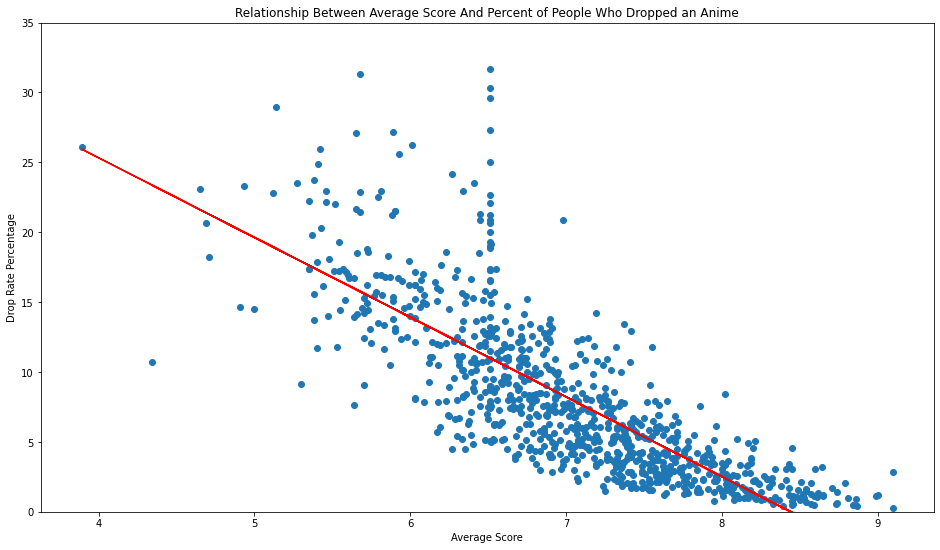

In [15]:
fig, ax = plt.subplots(figsize = (16, 9))
x, y = df['Score'], df['DropRatio(%)']
ax.scatter(x, y)
ax.set_xlabel('Average Score')
ax.set_ylabel('Drop Rate Percentage')
ax.set_title('Relationship Between Average Score And Percent of People Who Dropped an Anime')
ax.set_ylim(0, 35)
m, b = np.polyfit(x, y, 1)
fig.patch.set_facecolor('xkcd:white')
plt.plot(x, m * x + b, color = 'red')


There is an inverse relationship between average score and percentage of viewers that loses interest in an anime. Generally, the higher the score, the larger the percentage of the viewer base will remain interested in an anime. Conversely, lower score means users are more likely to drop an anime mid series. The line occurring around score 6.5 is a byproduct of our missing data cleaning process.

### 5.2 Rating and Run Length of the 1000 Most Popular Anime


In [16]:
df = anime_list.dropna(axis=0, subset=['Rating', 'RunLength'])
heatmap_list = []
for i in list_of_ratings:
    count = []
    for j in list_of_run_length:
        df_heatmap = df[(df['Rating'] == i) & (df['RunLength'] == j) & (df['Popularity'] <= 1000)]
        count.append(len(df_heatmap['Popularity']))
    heatmap_list.append(count)
heatmap_df = pd.DataFrame(heatmap_list, columns = list_of_run_length, index = list_of_ratings)


Text(0.5, 1.0, 'Rating and Run Length of The 1000 Most Popular Anime Released Between 2015 - 2020')

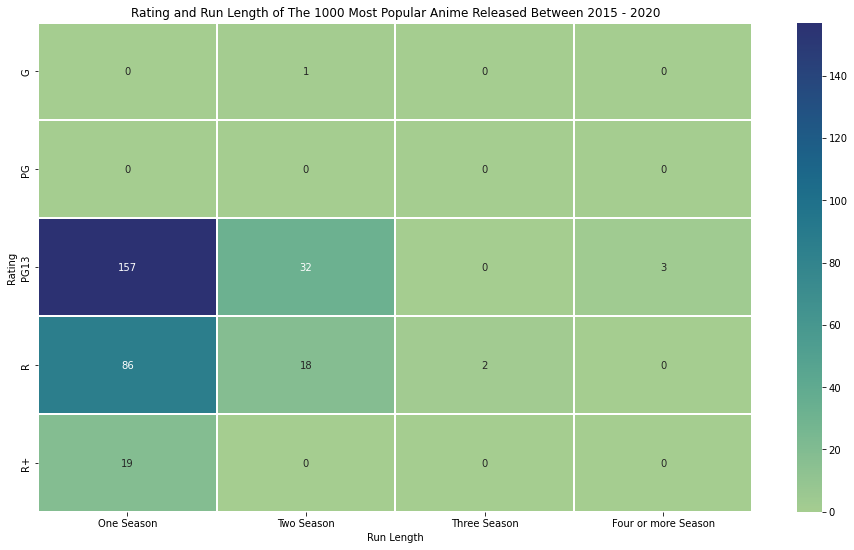

In [17]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
ax = sns.heatmap(heatmap_df, linewidths=2, annot=True, fmt=".0f", cmap='crest')
ax.set(xlabel='Run Length', ylabel='Rating')
ax.set_title('Rating and Run Length of The 1000 Most Popular Anime Released Between 2015 - 2020')



Only 322 of the most popular anime were released between 2015 and 2020. Among the 322 anime, majority of these anime were only one season in length and some were two seasons long. Rarely any anime were three season and longer. Anime rated G and PG only made 1 appearance. This indicate anime watchers not interested in anime below PG-13. The top three combination of rating and run length were One Season long anime rated PG13, One Season long anime rated R and Two Season long anime rated PG13. We suggest anime one season long rated PG13 or R with some consideration for two season long anime.

### 5.3 Anime Genre Popularity in General

When comparing anime, there are some bias we need to be aware of. Generally older anime have more view because they have been accumulating over time. In addition, older anime are judged less harshly because standards were lower when they premiered. An anime that was consider peak or extremely good for it's time may be considered mediocre by today's standards. To circumvent this bias, we will be comparing anime to anime released in the same season. We will obtain the top 5 genres, 8 producers and 8 studios from each season using two different metrics, viewer interest and viewer satisfaction. If there is a tie for last place, we will include all entries that tied. Then we will count the number of time each genres, producers and studio appears within the top 5/10 to find the overall best genre, producers and studios by viewer interest and viewer satisfaction. This will show which genre, producer and studio we should look out for. For producers and studios we select 8 instead of 5 because there are many producer and studios while genres are much few in numbers. There are some bias that are unaccounted for in this analysis. This method of studio selection is bias towards studios that produce anime extremely often. Some studios who does great work, but doesn't output as much anime as other studios are will not appear as favorable in comparison to studios that output plenty of anime. One good example is Ufotable, a studio known to produce some of the best industry standard animation available. An example of their work is Demon Slayer. 

In [18]:
# Create dictionary containing information for top 5 genres, top 8 producers and top 8 studios for one season
def seasonal_calculation(season):
    seasonal_df = anime_list[anime_list['Premiered'] == season]
    genre_df = pd.DataFrame(columns=['Genre', 'Avg Score', 'Avg Members'])
    producer_df = pd.DataFrame(columns=['Producer', 'Avg Score', 'Avg Members'])
    studio_df = pd.DataFrame(columns=['Studio', 'Avg Score', 'Avg Members'])
    for genres in list_of_genres:
        df = filter_columnlist(seasonal_df, 'Genres', [genres], include=True)
        avg_score = df['Score'].mean(skipna=True)
        avg_members = df['Members'].mean(skipna=True)
        genre_df = genre_df.append({'Genre': genres, 'Avg Score': round(avg_score, 2), 'Avg Members': round(avg_members, 2)}, ignore_index=True)
    for producers in list_of_producers:
        df = filter_columnlist(seasonal_df, 'Producers', [producers], include=True)
        avg_score = df['Score'].mean(skipna=True)
        avg_members = df['Members'].mean(skipna=True)
        producer_df = producer_df.append({'Producer': producers, 'Avg Score': round(avg_score, 2), 'Avg Members': round(avg_members, 2)}, ignore_index=True)
    for studios in list_of_studios:
        df = filter_columnlist(seasonal_df, 'Studios', [studios], include=True)
        avg_score = df['Score'].mean(skipna=True)
        avg_members = df['Members'].mean(skipna=True)
        studio_df = studio_df.append({'Studio': studios, 'Avg Score': round(avg_score, 2), 'Avg Members': round(avg_members, 2)}, ignore_index=True)
        
    genre_dict = {
    'avg_score': genre_df[['Genre', 'Avg Score']].nlargest(n=5, columns='Avg Score', keep='all'),
    'avg_members': genre_df[['Genre', 'Avg Members']].nlargest(n=5, columns='Avg Members', keep='all')
    }
    producer_dict = {
    'avg_score': producer_df[['Producer', 'Avg Score']].nlargest(n=8, columns='Avg Score', keep='all'),
    'avg_members': producer_df[['Producer', 'Avg Members']].nlargest(n=8, columns='Avg Members', keep='all')
    }
    studio_dict = {
    'avg_score': studio_df[['Studio', 'Avg Score']].nlargest(n=8, columns='Avg Score', keep='all'),
    'avg_members': studio_df[['Studio', 'Avg Members']].nlargest(n=8, columns='Avg Members', keep='all')
    }
    seasonal_dict = {'genre': genre_dict, 'producer': producer_dict, 'studio': studio_dict}
    return seasonal_dict
 
        

In [19]:
# Create dictionary for genre, producer and studio containing all seasons
genre_time_series = {}
producer_time_series = {}
studio_time_series = {}
for seasons in list_of_premiered:
    seasonal_data = seasonal_calculation(seasons)
    genre_time_series[seasons] = seasonal_data['genre']
    producer_time_series[seasons] = seasonal_data['producer']
    studio_time_series[seasons] = seasonal_data['studio']


In [20]:
# Add all occurrence into one list. Separated by avg score and avg members
genre_avg_score = []
genre_avg_members = []
producer_avg_score = []
producer_avg_members = []
studio_avg_score = []
studio_avg_members = []

for seasons in list_of_premiered:
    genre_avg_score = genre_avg_score + genre_time_series[seasons]['avg_score']['Genre'].tolist()
    genre_avg_members = genre_avg_members + genre_time_series[seasons]['avg_members']['Genre'].tolist()
    producer_avg_score = producer_avg_score + producer_time_series[seasons]['avg_score']['Producer'].tolist()
    producer_avg_members = producer_avg_members + producer_time_series[seasons]['avg_members']['Producer'].tolist()
    studio_avg_score = studio_avg_score + studio_time_series[seasons]['avg_score']['Studio'].tolist()
    studio_avg_members = studio_avg_members + studio_time_series[seasons]['avg_members']['Studio'].tolist()

Text(0.5, 1.0, 'Number of Times Each Genre Made Seasonal Top 5 In Term of Average Interest')

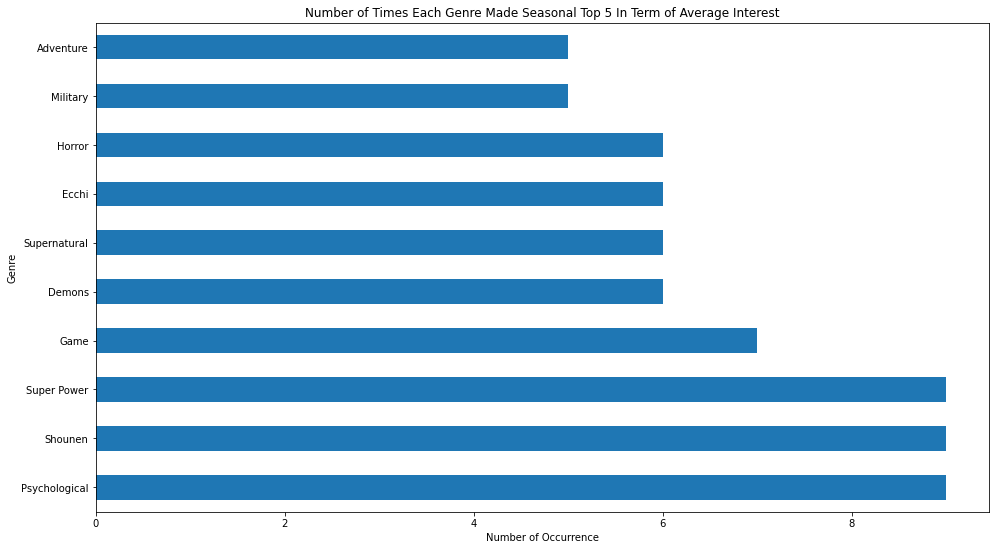

In [21]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
pd.Series(genre_avg_members).value_counts().head(10).plot(kind='barh', figsize = (16, 9))
plt.xlabel("Number of Occurrence")
plt.ylabel("Genre")
plt.title("Number of Times Each Genre Made Seasonal Top 5 In Term of Average Interest")


Text(0.5, 1.0, 'Number of Times Each Genre Made Seasonal Top 5 In Term of Average Satisfaction')

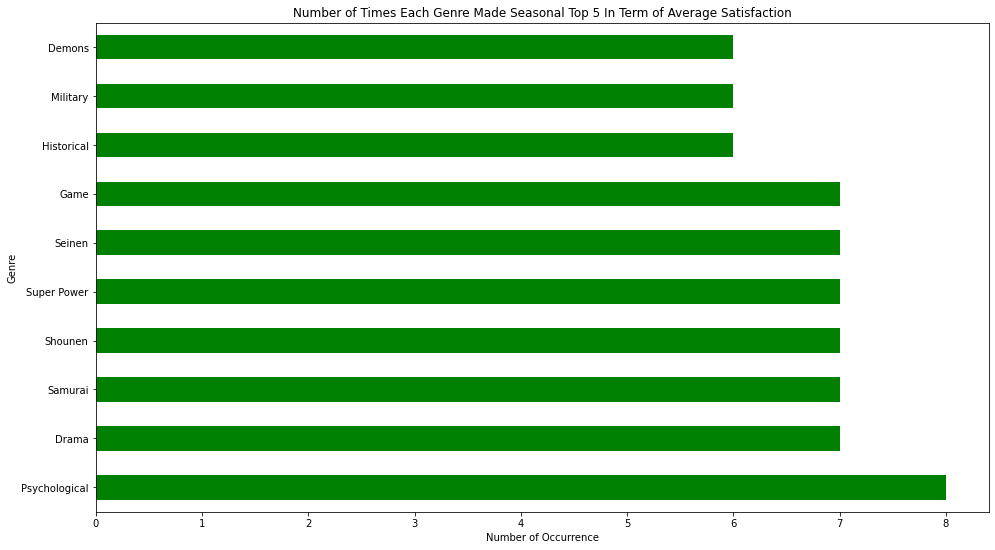

In [22]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
pd.Series(genre_avg_score).value_counts().head(10).plot(kind='barh', figsize = (16, 9), color='green')
plt.xlabel("Number of Occurrence")
plt.ylabel("Genre")
plt.title("Number of Times Each Genre Made Seasonal Top 5 In Term of Average Satisfaction")

The genre Shounen, Superpower and Psychological are the most popular genres in term of both viewer interest and satisfaction. Surprisingly the Game and Demon genre has above average viewer interest and a surprisingly high viewer satisfaction count.

Text(0.5, 1.0, 'Number of Times Each Producer Made Seasonal Top 8 In Term of Average Interest')

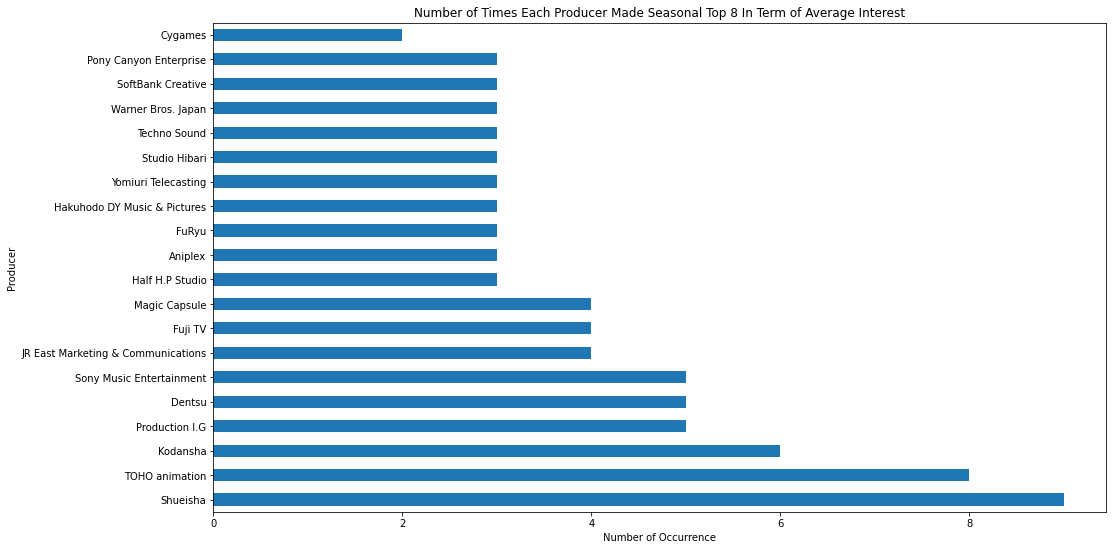

In [23]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
pd.Series(producer_avg_members).value_counts().head(20).plot(kind='barh', figsize = (16, 9))
plt.xlabel("Number of Occurrence")
plt.ylabel("Producer")
plt.title("Number of Times Each Producer Made Seasonal Top 8 In Term of Average Interest")

Text(0.5, 1.0, 'Number of Times Each Producer Made Seasonal Top 8 In Term of Average Satisfaction')

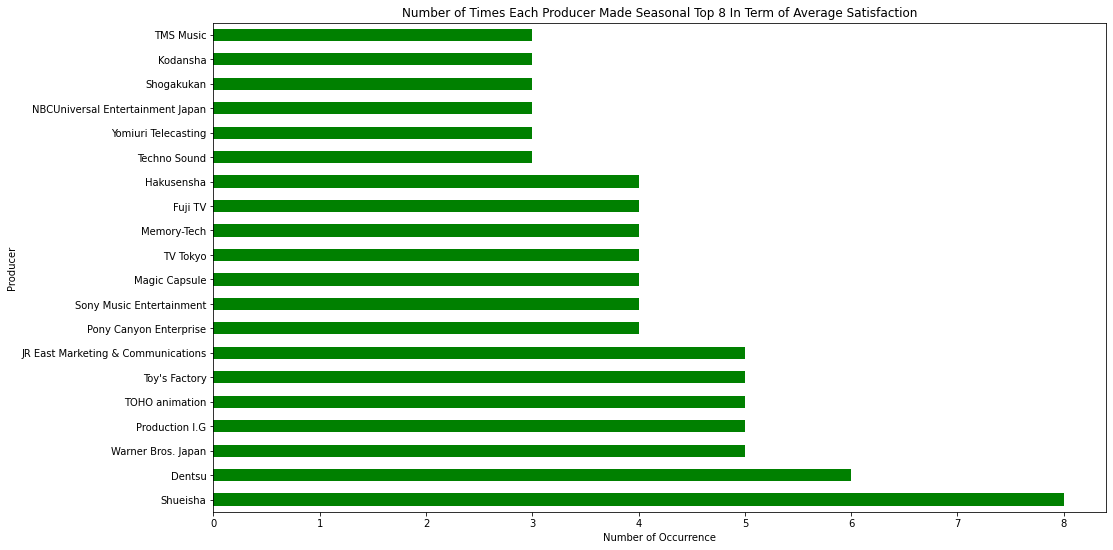

In [24]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
pd.Series(producer_avg_score).value_counts().head(20).plot(kind='barh', figsize = (16, 9), color='green')
plt.xlabel("Number of Occurrence")
plt.ylabel("Producer")
plt.title("Number of Times Each Producer Made Seasonal Top 8 In Term of Average Satisfaction")


For the producer section, we consider an occurrences of 5 or higher to be good. We found Shueisha top the chart in both viewer interest and viewer satisfaction by a significant margin. This is expected because Shueisha publishes many popular manga series. Generally an anime adaption of an extremely popular manga will get people's capture plenty of viewer interest. In addition, a large proportion of the manga reader fan base will watch the adaption. Dentsu and TOHO Animation performs well by our standards as well. Other producers worth noticing are Production I.G, Sony Music Entertainment and J.R East Marketing. While a bit below our definition of good, Fuji TV and Magic Capsule is worth some consideration.

Text(0.5, 1.0, 'Number of Times Each Studio Made Seasonal Top 8 In Term of Average Interest')

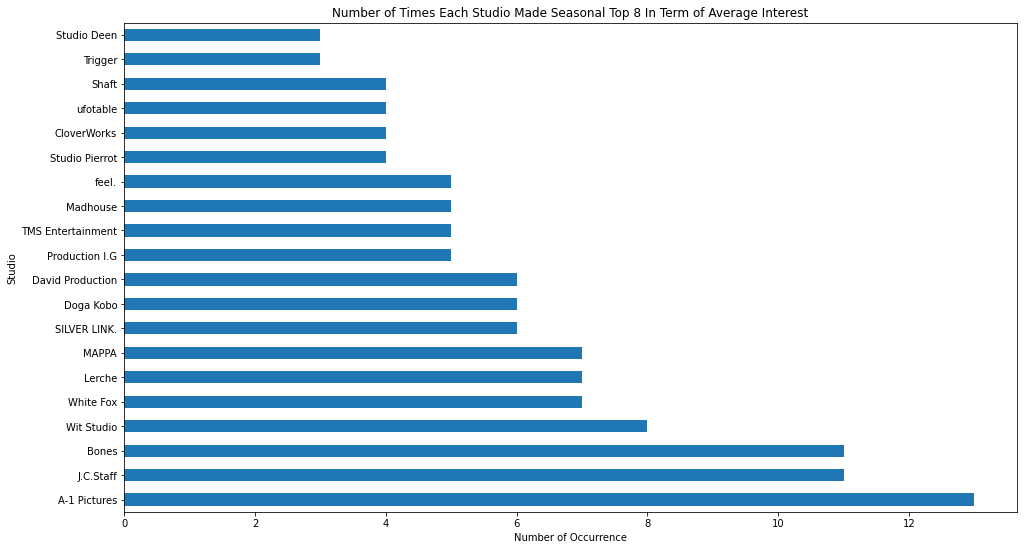

In [25]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
pd.Series(studio_avg_members).value_counts().head(20).plot(kind='barh', figsize = (16, 9))
plt.xlabel("Number of Occurrence")
plt.ylabel("Studio")
plt.title("Number of Times Each Studio Made Seasonal Top 8 In Term of Average Interest")

Text(0.5, 1.0, 'Number of Times Each Studio Made Seasonal Top 8 In Term of Average Satisfaction')

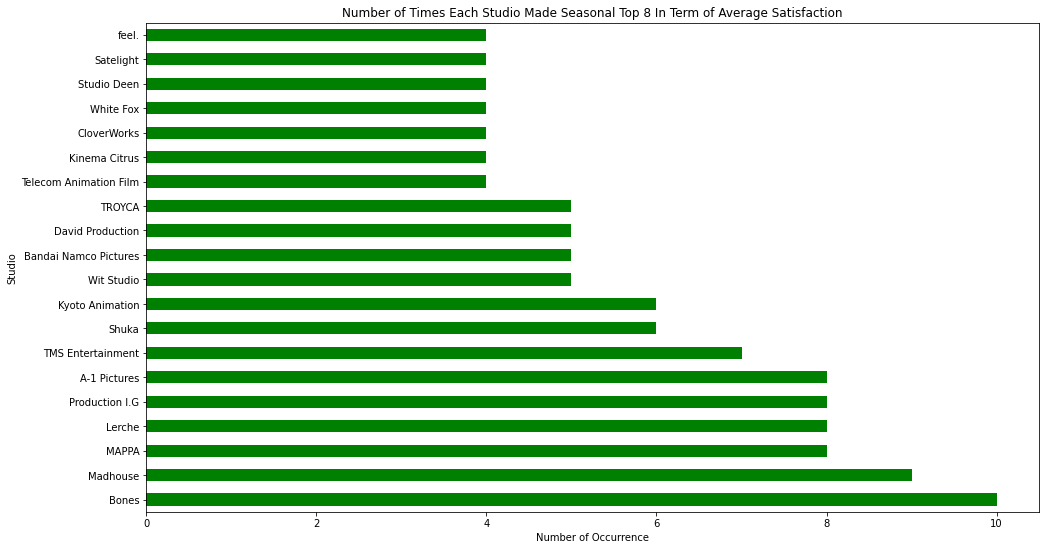

In [26]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
pd.Series(studio_avg_score).value_counts().head(20).plot(kind='barh', figsize = (16, 9), color='green')
plt.xlabel("Number of Occurrence")
plt.ylabel("Studio")
plt.title("Number of Times Each Studio Made Seasonal Top 8 In Term of Average Satisfaction")

We will consider an occurrence of 6 or higher to be considered good. We found A-1 Pictures and Bones to have stellar performance in the viewer interest and viewer satisfaction front. The studios
Lerche and MAPPA perform well in both categories. For viewer interest, Doga Kobo, David Production, Silver Link, White Fox, Wit Studio and J.C Staff does well, but below average in viewer satisfaction. On the other hand, in viewer satisfaction, Madhouse, Production I.G , TMS Entertainment, Shuka and Kyoto Animation does well, but below average in viewer interest.


### 5.4 Identify Trends In Anime Selection From Other Licensors

Here we filter out licensors that are not streaming services and compare the genres, producers and studios of the anime each streaming service purchased.

In [27]:
licensor_avg_member_df = pd.DataFrame(columns=['Licensors', 'Avg Members', 'License Count'])
for licensors in list_of_licensors:
    df = filter_columnlist(anime_list, 'Licensors', [licensors], include=True)
    avg_members = df['Members'].mean(skipna=True)
    number_of_license_owned = len(df['Members'])
    licensor_avg_member_df = licensor_avg_member_df.append({'Licensors': licensors, 'Avg Members': round(avg_members, 2), 'License Count': number_of_license_owned}, ignore_index=True)
licensor_avg_member_df.sort_values('Avg Members', ascending=False)

,Licensors,Avg Members,License Count
8,VIZ Media,426116.50,14
5,Aniplex of America,360443.13,62
3,Crunchyroll,320901.17,54
7,Discotek Media,275293.00,12
2,Funimation,244613.23,324
10,Maiden Japan,213851.00,1
1,Sentai Filmworks,177542.80,140
4,Netflix,170989.00,5
6,Ponycan USA,117037.84,19
12,NBCUniversal Entertainment Japan,100399.00,1


Only three of these Licensors are directly involved in streaming anime. Also Netflix has only recently started licensing anime towards the end of this time period, resulting in a low License Count. Thus we will be focused on trend in Crunchyroll and Funimation lineup to understand their anime selection. 

Note: While fact checking some raw data, we found an anime named Jujutsu Kaisen whose Licensor came up as unknown but is streamed by both Crunchyroll and Funimation. In addition, the updated animelist lists this anime licensed by Viz Media. Since it requires too much resource to search for every example of this type of situation and correct them, we'll just acknowledge this section doesn't accurately reflect all of Crunchyroll and Funimation anime selection. 

Text(0.5, 1.0, 'Number of Times a Genre is Licensed By Crunchyroll')

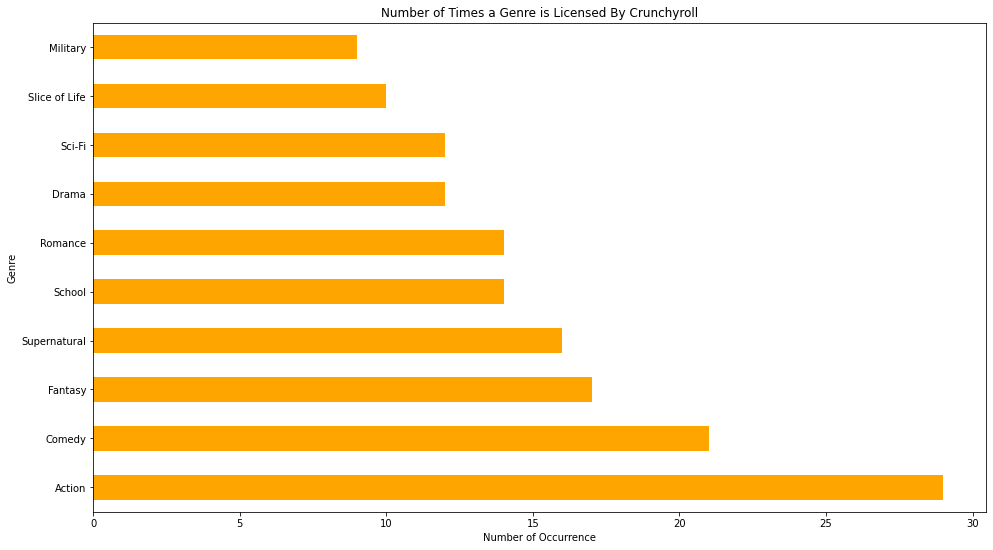

In [28]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
crunchyroll_df = filter_columnlist(anime_list, 'Licensors', ['Crunchyroll'], include=True)
combine_lists(crunchyroll_df['Genres']).value_counts().head(10).plot(kind='barh', figsize = (16, 9), color='orange')
plt.xlabel("Number of Occurrence")
plt.ylabel("Genre")
plt.title("Number of Times a Genre is Licensed By Crunchyroll")

Text(0.5, 1.0, 'Number of Times a Genre is Licensed By Funimation')

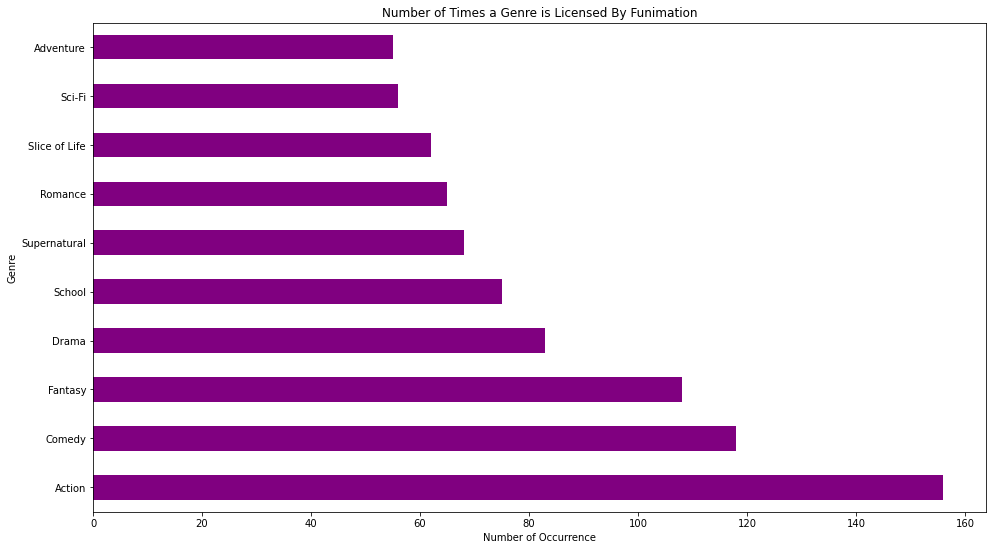

In [29]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
funimation_df = filter_columnlist(anime_list, 'Licensors', ['Funimation'], include=True)
combine_lists(funimation_df['Genres']).value_counts().head(10).plot(kind='barh', figsize = (16, 9), color='purple')
plt.xlabel("Number of Occurrence")
plt.ylabel("Genre")
plt.title("Number of Times a Genre is Licensed By Funimation")

The top 3 Genre for both Crunchyroll and Funimation are Action, Comedy and Fantasy. This is extremely different from the top genres we found from our previous analysis. In the previous one, we found Shounen, Psychological, Superpower and Demon to perform extremely well. However of the mentioned genres, only Shounen makes an appearance on the graph for Funimation. We suspect there is an over saturation of anime with these genres and the quantity of lower quality anime pulls down the average viewer interest and average viewer satisfaction significantly. Thus the Action, Comedy or Fantasy labeling is not a good indicator of popularity. 

Text(0.5, 1.0, 'Number of Time Crunchyroll License an Anime By a Certain Producer')

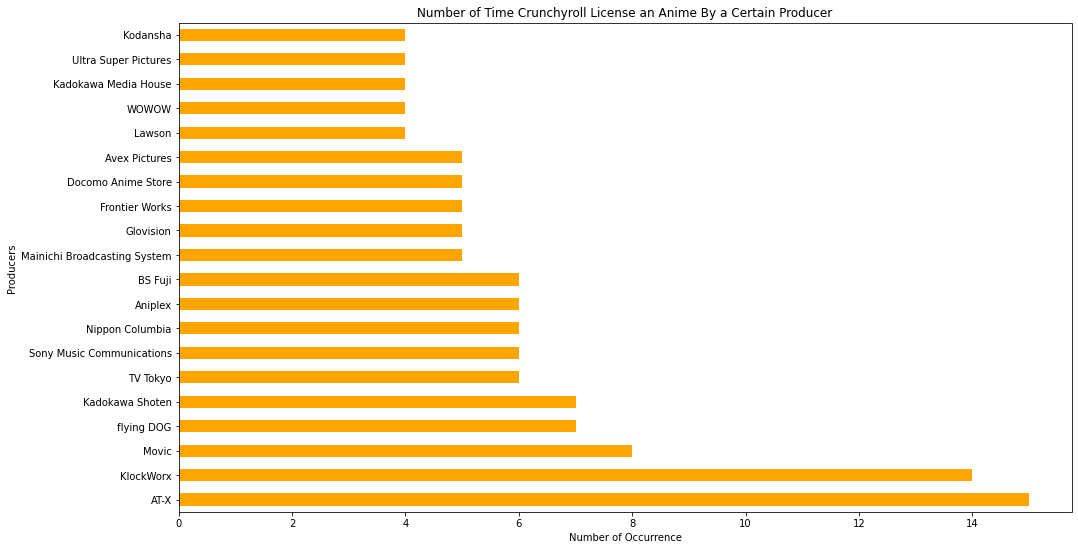

In [30]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
combine_lists(crunchyroll_df['Producers']).value_counts().head(20).plot(kind='barh', figsize = (16, 9), color='orange')
plt.xlabel("Number of Occurrence")
plt.ylabel("Producers")
plt.title("Number of Time Crunchyroll License an Anime By a Certain Producer")

Text(0.5, 1.0, 'Number of Time Funimation License an Anime By a Certain Producer')

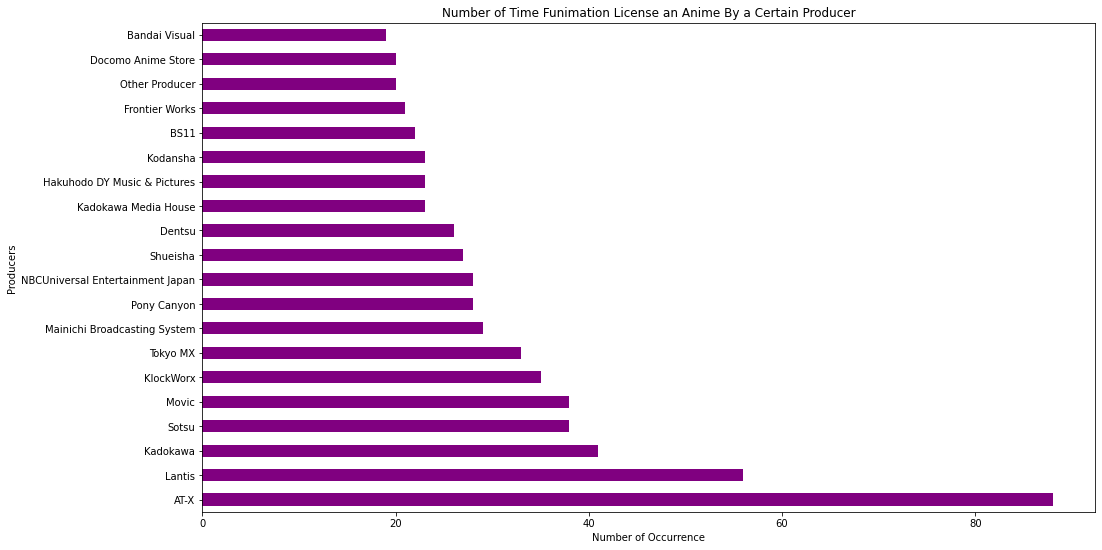

In [31]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
combine_lists(funimation_df['Producers']).value_counts().head(20).plot(kind='barh', figsize = (16, 9), color='purple')
plt.xlabel("Number of Occurrence")
plt.ylabel("Producers")
plt.title("Number of Time Funimation License an Anime By a Certain Producer")

An abnormally large fraction of anime licensed by Crunchyroll and Funimation are produced by AT-X. The data shows AT-X funds plenty of anime projects, resulting in a high number of occurrence. The producer analysis we performed in Section 5.3 shows on average the work they fund aren't particularly popular. A significant amount of producer on this list follow the same trend as AT-X, thus we don't believe Crunchyroll or Funimation choice in producers will be insightful. 

Text(0.5, 1.0, 'Number of Time Crunchyroll License an Anime By a Certain Studio')

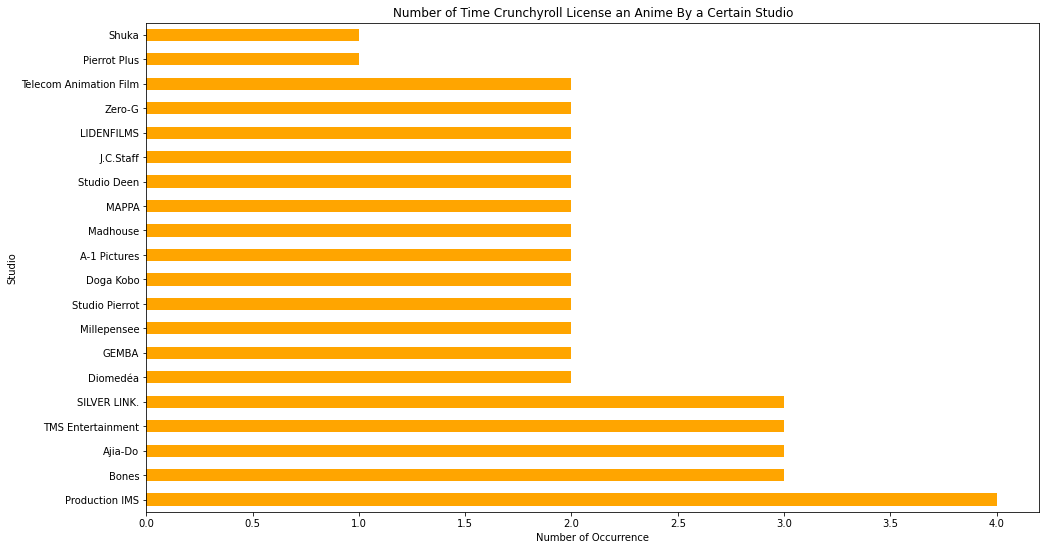

In [32]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
combine_lists(crunchyroll_df['Studios']).value_counts().head(20).plot(kind='barh', figsize = (16, 9), color='orange')
plt.xlabel("Number of Occurrence")
plt.ylabel("Studio")
plt.title("Number of Time Crunchyroll License an Anime By a Certain Studio")

Text(0.5, 1.0, 'Number of Time Funimation License an Anime By a Certain Studio')

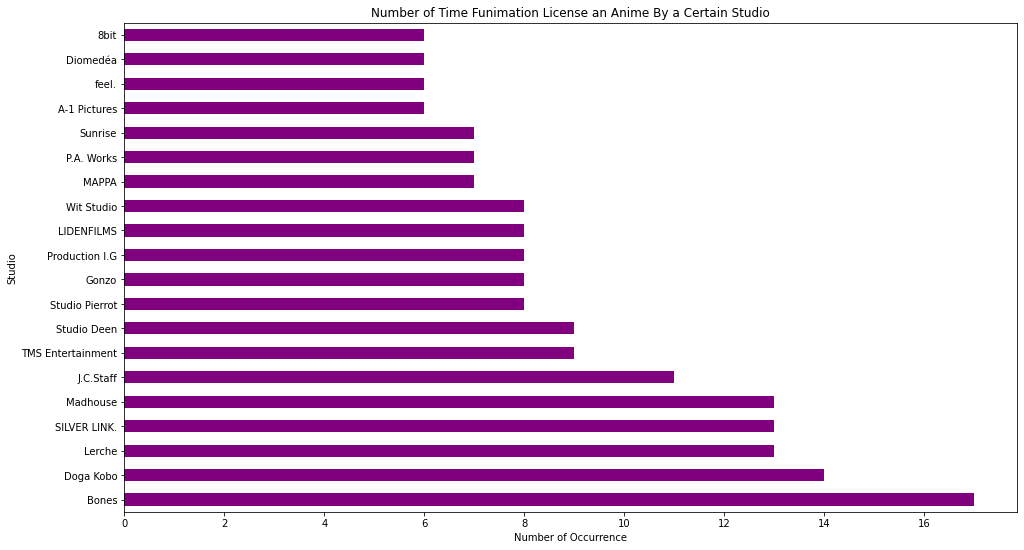

In [33]:
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
combine_lists(funimation_df['Studios']).value_counts().head(20).plot(kind='barh', figsize = (16, 9), color='purple')
plt.xlabel("Number of Occurrence")
plt.ylabel("Studio")
plt.title("Number of Time Funimation License an Anime By a Certain Studio")

Crunchyroll either don't have a preferred studio when obtaining anime license or they haven't obtained enough license for a notable trend to show up. Funimation's catalogue on the other hand is in possession of more licenses thus trends will be more apparent. Thus we will focus on Funimation for this section. For Funimation, anime animated by Bones, Doga Kobo, Lerche, SILVER LINK., Madhouse and J.C Staff make up the highest percentage of their anime licenses. Unlike the Genre segment, over saturation doesn't play a factor in their production quality nor do the studios produce an abnormally high amount of anime. 

### 5.5 Does Sources Impact Popularity

In [34]:
source_df = pd.DataFrame(columns=['Source', 'Avg Scores', 'Avg Members', 'Count'])

for sources in list_of_sources:
    df = anime_list[anime_list['Source'] == sources]
    avg_scores = df['Score'].mean(skipna=True)
    avg_members = df['Members'].mean(skipna=True)
    count = len(df['Score'])
    source_df = source_df.append({'Source': sources, 'Avg Members': round(avg_members, 2), 'Avg Scores': round(avg_scores, 2), 'Count': count}, ignore_index=True)


Text(0.5, 1.0, 'Average Interest of Source Material Anime Adaption')

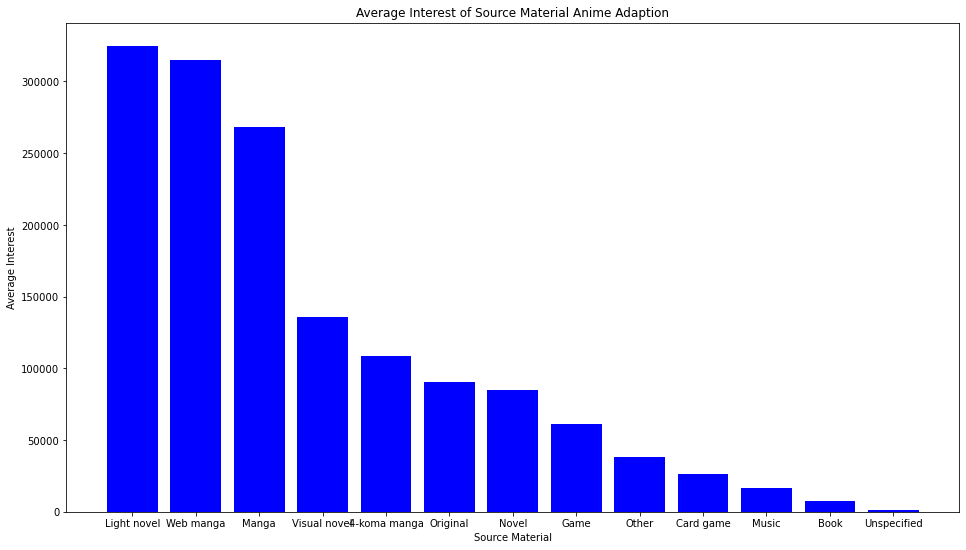

In [35]:
source_df = source_df.sort_values('Avg Members', ascending=False)
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
x, y = source_df['Source'], source_df['Avg Members']
ax.bar(x, y, color='blue')
ax.set_xlabel('Source Material')
ax.set_ylabel('Average Interest')
ax.set_title('Average Interest of Source Material Anime Adaption')


Text(0.5, 1.0, 'Average Score of Source Material Anime Adaption')

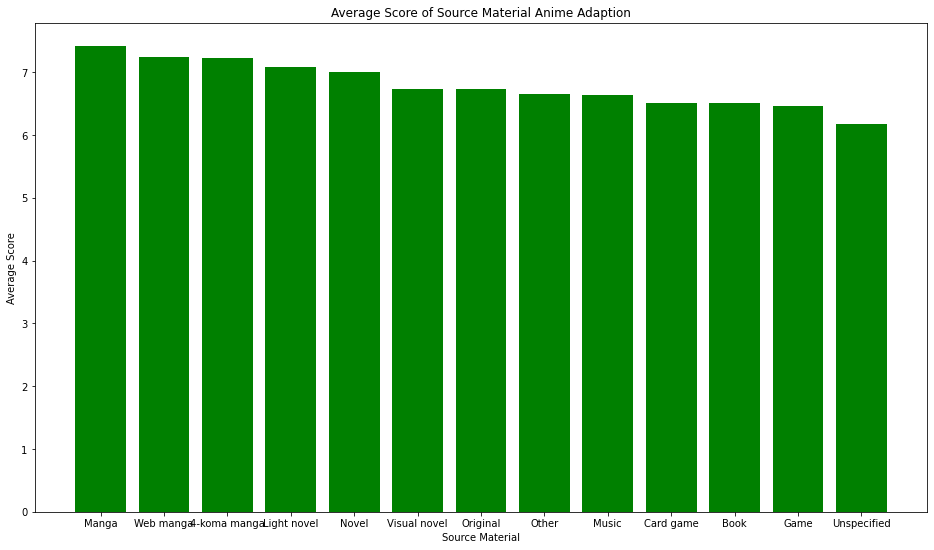

In [36]:
source_df = source_df.sort_values('Avg Scores', ascending=False)
fig, ax = plt.subplots(figsize = (16, 9))
fig.patch.set_facecolor('xkcd:white')
x, y = source_df['Source'], source_df['Avg Scores']
ax.bar(x, y, color='green')
ax.set_xlabel('Source Material')
ax.set_ylabel('Average Score')
ax.set_title('Average Score of Source Material Anime Adaption')

Light novel, Web manga and Manga are the top 3 in term of average viewer interest. This is expected since a large portion of the source material's fan base will watch the adaption and generally only successful series will get an adaption. Visual Novel and 4-koma manga are on a similar boat but appeal to a smaller audience which will explain their follow up placing. Anime adaption of video game are known to be historically unsuccessful or have no merits over playing the original game, hence the extremely low interest. Original anime have no source material, thus have no fan base for interest to transfer over nor a track record to indicate it's potential. So we expect Video Game and Original anime to not perform well. Anime outside the type of source material we've mentioned are extremely uncommon and generally don't perform extremely well. Surprisingly in terms of average viewer satisfaction, the score difference isn't wide. With the given data, we suggest prioritizing anime adapted from light novel, web manga and manga while avoiding anime originals and video game adaptions. 

# 6. Act

Our objective is to identify trends that would indicate an anime's success. We highly suggest before purchasing a license, the purchaser examine the source material's track record. From personal experience, public reception to a series's source material is the biggest indicator of success. Our findings are the following:
1. Anime that are rated PG-13 or R and one to two seasons long tend to perform the best, particularly anime that are one season long and rated PG-13. 
2. For Genres to look for: Shounen, Psychological, Superpower, Game and Demon perform the best. The genre Action, Comedy and Fantasy are not useful indicator for an anime's popularity. 
3. For producers, we recommend looking at projects funded by Shueisha, TOHO Animation, Dentsu. Other producers worth looking into are Kodansha, Production I.G, Sony Music Entertainment, J.R East Marketing, Fuji TV and Magic Capsule. AT-X as a producer is not a useful indicator of success. 
4. For studios we suggest anime animated by A-1 Pictures, Bones, Lerche and MAPPA based on performance. Doga Kobo, David Production,Silver Link., White Fox, Wit Studio, J.C Staff, Madhouse, Production I.G, T.M.S Entertainment, 
Shuka and Kyoto Animation are studios with performance comparable with the previously mentioned studios.
5. Anime with the following source material, Light Novel, Web manga and Manga tend to perform better. Anime originating from Visual Novel and 4-koma manga should be given some consideration, otherwise anime from other sources are not worth considering. 